In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Setup

In [3]:
n = 1000
lam = np.linspace(1e-2,1e2,n)
b = np.ones(n,dtype=np.longdouble)
b /= np.linalg.norm(b)

lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

lmin_ = lmin/2
lmax_ = 2*lmax

In [4]:
w = 0

# norm to measure function approximation and linear system errors
B = lam

In [5]:
K = 200
reorth=True
Q,(a_,b_) = exact_lanczos(lam.astype(np.longdouble),b.astype(np.longdouble),K+1,reorth=reorth)

In [6]:
plot_tol = 1e-14

In [7]:
T = np.zeros((3,K+1))
T[0,1:] = b_
T[1] = a_-w
T[2,:-1] = b_

e1 = np.zeros(K+1)
e1[0] = 1

In [8]:
err_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = (1/(lam-w))*b - np.linalg.norm(b)*Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1])
        err_CG[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_CG[k] < plot_tol:
        break

In [9]:
res_CG = np.full(K,np.nan)

for k in range(0,K):
    try:
        r = b - np.linalg.norm(b)*(lam-w)*(Q[:,:k+1]@sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1]))
        res_CG[k] = np.sqrt( r@r )
    except: pass
    
    if res_CG[k] < plot_tol:
        break

In [10]:
Anorm_estimate = np.full(K,np.nan)
Anorm_bound = np.full(K,np.nan)

d = 10

for k in range(0,K):
    try:
        Tk_inv_e1 = sp.linalg.solve_banded((1,1),T[:,:k+1],e1[:k+1])
        e = (1/(lam-w))*b - np.linalg.norm(b)*Q[:,:k+1]@Tk_inv_e1
                
        if k+d+1<K:
            Tkd_inv_e1 = sp.linalg.solve_banded((1,1),T[:,:k+d+1],e1[:k+d+1])
            
        Anorm_estimate[k] = np.linalg.norm(b)*np.sqrt(e1[:k+d+1]@Tkd_inv_e1 - e1[:k+1]@Tk_inv_e1)
        Anorm_bound[k] = np.sqrt(np.linalg.norm(b)**2*(e1[:k+d+1]@Tkd_inv_e1 - e1[:k+1]@Tk_inv_e1) + (1/lmin) * res_CG[k+d+1]**2)

        
    except: pass
    
    if err_CG[k] < plot_tol:
        break

## $f(x) = \sqrt{x}$, $\Gamma =$ circle

In [11]:
def f(x):
    return np.sqrt(x)

fAb = f(lam)*b

In [12]:
err_lanczos = np.full(K,np.nan)

for k in range(0,K):
    try:
        e = fAb - lanczos_FA(f,Q[:,:k+1],a_[:k+1],b_[:k],normb=np.linalg.norm(b))
        err_lanczos[k] = np.sqrt( e.T*B@e )
    except: pass
    
    if err_lanczos[k] < plot_tol:
        break

In [13]:
a_priori_bound_circle = np.full(K,np.inf)
a_posteriori_bound_circle = np.full(K,np.inf)
exact_bound_circle = np.full(K,np.inf)

def Gamma(t):
    radius = lmax-lmin/100

    z = radius*np.exp(1j*t)+lmax
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

for k in range(1,K):
    a_priori_bound_circle[k-1] = 2*get_a_priori_bound(f,Gamma,[0,np.pi],k,w,lmin,lmax)[0]
    a_posteriori_bound_circle[k-1] = 2*get_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin,lmax)[0]
    exact_bound_circle[k-1] = 2*get_exact_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lam)[0]



In [14]:
a_priori_bound_circle_approx_spectrum = np.full(K,np.inf)
a_posteriori_bound_circle_approx_spectrum = np.full(K,np.inf)
    
def Gamma(t):


    radius = lmax_ - lmin_/100

    z = radius*np.exp(1j*t)+lmax_
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

for k in range(1,K):
    a_priori_bound_circle_approx_spectrum[k-1] = 2*get_a_priori_bound(f,Gamma,[0,np.pi],k,w,lmin_,lmax_)[0]
    a_posteriori_bound_circle_approx_spectrum[k-1] = 2*get_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_)[0]



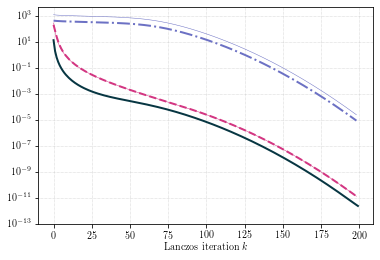

In [15]:
plt.figure(figsize=(6,4))

plt.plot(err_lanczos,linestyle='-',linewidth=2,color='#073642')

#plt.plot(sub_mult_bound,linestyle=(0,(4,2,1,3)),linewidth=1,color='#2aa198')
#plt.plot(triangle_bound,linestyle=(0,(7,5)),linewidth=1,color='#859900')
#plt.plot(full_bound,linestyle='-',linewidth=1,color='#b58900')

plt.plot(a_priori_bound_circle*err_CG,linestyle='-.',linewidth=2,color='#6c71c4')
#plt.plot(np.sqrt(2)*lmax**3/2*err_CG,linestyle='-.',linewidth=2,color='red')
plt.plot(a_posteriori_bound_circle*err_CG,linestyle='--',linewidth=2,color='#d33682')
#plt.plot(exact_bound_circle*err_CG,linestyle='--',linewidth=2,color='red')


plt.plot(a_priori_bound_circle_approx_spectrum*err_CG,linestyle='-',linewidth=.5,color='#6c71c4')
plt.plot(a_posteriori_bound_circle_approx_spectrum*err_CG,linestyle='-',linewidth=.5,color='#d33682')

#plt.plot(a_priori_bound*res_CG/lmin,linestyle='-.',linewidth=1,color='#6c71c4')
#plt.plot(a_posteriori_bound*res_CG/lmin,linestyle='--',linewidth=1,color='#d33682')


plt.yscale('log')

legend_elements = [Line2D([0],[0],linestyle='-',color='#073642',label='$\| f(\mathbf{A})\mathbf{b} - \\textsf{lan}_k(f) \|_\mathbf{{A}}$'),

                   Line2D([0],[0],linestyle='--',linewidth=2,color='#d33682',label='$(\\textrm{B1}) \: \| \\textsf{err}_k(w) \|_\mathbf{A}$, $S=\\mathcal{I}(\mathbf{A})$'),
                   Line2D([0],[0],linestyle='-.',linewidth=2,color='#6c71c4',label='$(\\textrm{B2}) \: \| \\textsf{err}_k(w) \|_\mathbf{A}$, $S=\\mathcal{I}(\mathbf{A})$'),

                   
 #                  Line2D([0],[0],linestyle=':',linewidth=1,color='#073642',label='$(\\textrm{B1}) \: (\\textrm{CN})$'),
                   Line2D([0],[0],linestyle='None'),
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#d33682',label='$S=\\tilde\\mathcal{I}(\mathbf{A})$'),
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#6c71c4',label='$S=\\tilde\\mathcal{I}(\mathbf{A})$'),
                  ]

#plt.legend(handles=legend_elements,loc='lower left',ncol=2)

#plt.plot(a_priori_bound_circle*2*np.linalg.norm(np.sqrt(B)*b)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**np.arange(K),linestyle=':',linewidth=1,color='#073642')

#for c in range(-1,1,3):
#    plt.plot(10**(c)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**np.arange(K),linestyle=':',linewidth=.5,color='#073642')

plt.grid(True,linestyle=':',linewidth=.5)

plt.ylim(1e-13,5e3)

#plt.title(f'$\mathbf{{A}}$-norm error bounds: $f(x) = \sqrt{{x}}$, circle contour')
plt.xlabel('Lanczos iteration $k$')

plt.savefig('imgs/sqrt_Anorm_circle.pdf',bbox_inches='tight')

## $f(x) = \sqrt{x}$, $\Gamma=$ line away from origin

In [16]:
a_priori_bound_wedge = np.full(K,np.inf)
a_posteriori_bound_wedge = np.full(K,np.inf)

def Gamma(t):
    z = 1e-16j - 1*t
    dz = -1
    
    return z,dz

for k in range(1,K):
    a_priori_bound_wedge[k-1] = 2*get_a_priori_bound(f,Gamma,[0,np.inf],k,w,lmin,lmax)[0]
    a_posteriori_bound_wedge[k-1] = 2*get_a_posteriori_bound(f,Gamma,[0,np.inf],a_[:k],b_[:k-1],w,lmin,lmax)[0]


In [17]:
a_priori_bound_wedge_approx_spectrum = np.full(K,np.inf)
a_posteriori_bound_wedge_approx_spectrum = np.full(K,np.inf)

def Gamma(t):
    z = 1e-16j - 1*t
    dz = -1
    
    return z,dz

for k in range(1,K):
    a_priori_bound_wedge_approx_spectrum[k-1] = 2*get_a_priori_bound(f,Gamma,[0,np.inf],k,w,lmin_,lmax_)[0]
    a_posteriori_bound_wedge_approx_spectrum[k-1] = 2*get_a_posteriori_bound(f,Gamma,[0,np.inf],a_[:k],b_[:k-1],w,lmin_,lmax_)[0]


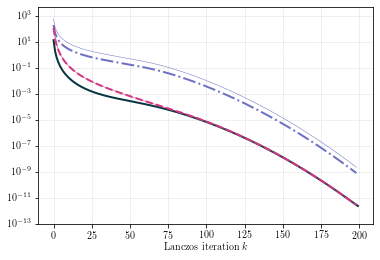

In [18]:
plt.figure(figsize=(6,4))

plt.plot(err_lanczos,linestyle='-',linewidth=2,color='#073642')

#plt.plot(sub_mult_bound,linestyle=(0,(4,2,1,3)),linewidth=1,color='#2aa198')
#plt.plot(triangle_bound,linestyle=(0,(7,5)),linewidth=1,color='#859900')
#plt.plot(full_bound,linestyle='-',linewidth=1,color='#b58900')
plt.plot(a_priori_bound_wedge*err_CG,linestyle='-.',linewidth=2,color='#6c71c4')
#plt.plot(lmax**(3/2) / (2*np.sqrt(np.pi)) * sp.special.gamma(-1/2+np.arange(K)) / sp.special.gamma(1+np.arange(K))*err_CG,linestyle='-.',linewidth=2,color='red')
plt.plot(a_posteriori_bound_wedge*err_CG,linestyle='--',linewidth=2,color='#d33682')

plt.plot(a_priori_bound_wedge_approx_spectrum*err_CG,linestyle='-',linewidth=.5,color='#6c71c4')
plt.plot(a_posteriori_bound_wedge_approx_spectrum*err_CG,linestyle='-',linewidth=.5,color='#d33682')

plt.yscale('log')

legend_elements = [Line2D([0],[0],linestyle='-',color='#073642',label='$\| f(\mathbf{A})\mathbf{b} - \\textsf{lan}_k(f) \|_\mathbf{{A}}$'),

                   Line2D([0],[0],linestyle='--',linewidth=2,color='#d33682',label='$(\\textrm{B1}) \: \| \\textsf{err}_k(w) \|_\mathbf{{A}}$'),
                   Line2D([0],[0],linestyle='-.',linewidth=2,color='#6c71c4',label='$(\\textrm{B2}) \: \| \\textsf{err}_k(w) \|_\mathbf{{A}}$'),
                   
                   Line2D([0],[0],linestyle='-',linewidth=.5,color='#073642',label='$\\exp(-2k/\\sqrt{\\kappa(\\mathbf{A}-w\\mathbf{I})})$')
                  ]

#plt.legend(handles=legend_elements,loc='lower left')

#plt.plot(a_priori_bound_wedge*2*np.linalg.norm(np.sqrt(B)*b)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**np.arange(K),linestyle=':',linewidth=1,color='#073642')


#for c in range(-10,6,3):
#    plt.plot(10**(c)*(( np.sqrt(kappa) - 1 )/( np.sqrt(kappa) + 1 ))**np.arange(K),linestyle=':',linewidth=.5,color='#073642')

plt.grid(True,linestyle=':',linewidth=.5)

plt.ylim(1e-13,5e3)

#plt.title(f'$\mathbf{{A}}$-norm error bounds: $f(x) = \sqrt{{x}}$, Pac-Man contour')
plt.xlabel('Lanczos iteration $k$')

plt.savefig('imgs/sqrt_Anorm_wedge.pdf',bbox_inches='tight')